
======================================== CONVERSATION LOG ========================================

👤 Human Message [1]:
--------------------------------------------------
Hello!

🔴 ERROR: Supervisor error: '"next_agent"'

======================================== END OF LOG ========================================



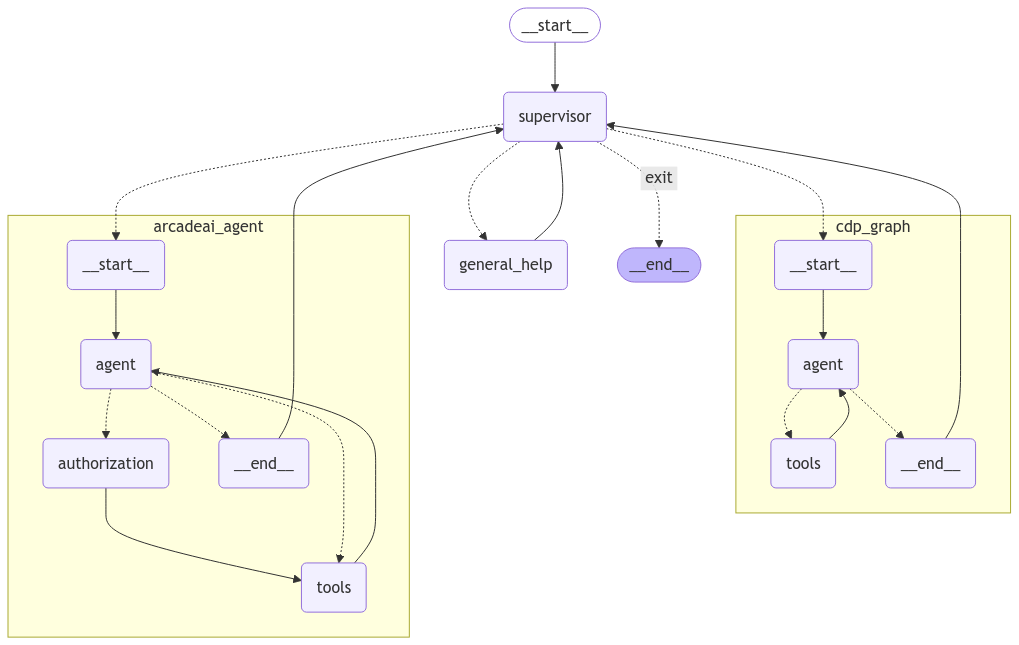

In [9]:
import import_ipynb
import cdp_agent
from cdp_agent import *
import arcade_agent
from arcade_agent import *
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict, List, Annotated, Optional, Literal
import operator
import traceback
import json
from IPython.display import Image, display

# ---------------------------
# Global Configuration
# ---------------------------
config = {}  # Global configuration for agent invocation.
memory = MemorySaver()  # Optional: Use MemorySaver for state persistence.

# ---------------------------
# Define Agent State & Options
# ---------------------------
# Define available agent options.
AgentOptions = Literal["cdp_graph", "arcadeai_agent", "general_help", "exit"]

class AgentState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], operator.add]
    current_agent: AgentOptions
    error: Optional[str]

# ---------------------------
# Build the Supervisor Workflow
# ---------------------------
supervisor_workflow = StateGraph(AgentState)

# Instantiate the LLM using ChatGoogleGenerativeAI with model "gemini-1.5-flash"
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

# Supervisor Prompt: The LLM is asked to decide which agent should process the request.
supervisor_prompt = ChatPromptTemplate.from_messages([
    ("system", (
        "You are a supervisor for a multi-agent system. Based on the user's last message, decide which specialized agent should handle the request. "
        "The available options are: 'cdp_graph' (for blockchain/NFT tasks), 'arcadeai_agent' (for Twitter tasks), 'general_help' (for greetings), "
        "or 'exit' (to terminate the conversation). Respond ONLY with a JSON object in the exact format: {\"next_agent\": \"<option>\"} "
        "with no additional text."
    )),
    ("human", "{message}")
])


# LLM-based Supervisor Node: Uses the prompt and LLM to determine the next agent.
def supervisor_node(state: AgentState) -> dict:
    try:
        if not state["messages"]:
            return {"current_agent": "general_help"}
        last_msg = state["messages"][-1].content.strip()
        if "exit" in last_msg.lower() or "goodbye" in last_msg.lower():
            return {"current_agent": "exit"}
        
        # Refined supervisor prompt should force a valid JSON response.
        prompt_messages = supervisor_prompt.format_messages(message=last_msg)
        response = llm.invoke(prompt_messages)
        print(f"Raw supervisor response: {response.content}")  # Log raw output
        
        try:
            routing = json.loads(response.content)
            next_agent = routing.get("next_agent")
            # Validate the option
            if next_agent not in ["cdp_graph", "arcadeai_agent", "general_help", "exit"]:
                print(f"Unexpected agent option: {next_agent}. Defaulting to general_help.")
                next_agent = "general_help"
        except Exception as parse_err:
            print(f"Error parsing response: {parse_err}. Raw response: {response.content}")
            next_agent = "general_help"
        return {"current_agent": next_agent}
    except Exception as e:
        return {
            "current_agent": "exit",
            "error": f"Supervisor error: {str(e)}"
        }

# LLM-based General Help Node: Used exclusively for greetings.
def llm_based_general_help_node(state: AgentState) -> dict:
    prompt = ChatPromptTemplate.from_messages([
        ("system", (
            "You are a friendly support assistant. When a user greets you (e.g., 'hi', 'hello'), respond with a warm welcome "
            "and a brief explanation that specialized agents handle Twitter and blockchain tasks."
        )),
        ("human", state["messages"][-1].content)
    ])
    messages = prompt.format_messages()  # No substitutions needed here if the message is already in the human part.
    response = llm.invoke(messages)
    return {"messages": [AIMessage(content=response.content)]}

# Specialized agent wrapper: Calls a specialized agent and captures its response.
def agent_wrapper(agent, name: str):
    def wrapper(state: AgentState) -> dict:
        try:
            response = agent.invoke(
                {"messages": state["messages"]},
                config,
                stream_mode="values"
            )
            return {
                "messages": response["messages"][-1:],
                "error": None
            }
        except Exception as e:
            traceback.print_exc()
            return {
                "messages": [AIMessage(content=f"⚠️ {name} error: {str(e)}")],
                "error": str(e)
            }
    return wrapper

# ---------------------------
# Add Nodes to the Workflow
# ---------------------------
supervisor_workflow.add_node("supervisor", supervisor_node)
supervisor_workflow.add_node("general_help", llm_based_general_help_node)
supervisor_workflow.add_node("cdp_graph", agent_wrapper(cdp_graph, "CDP Agent"))
supervisor_workflow.add_node("arcadeai_agent", agent_wrapper(arcadeai_agent, "Arcade AI Agent"))

# Conditional Routing: Uses the supervisor node's output to determine the next agent.
def route_to_agent(state: AgentState) -> str:
    if state.get("error"):
        return "exit"
    return state["current_agent"]

supervisor_workflow.add_conditional_edges(
    "supervisor",
    route_to_agent,
    {
        "cdp_graph": "cdp_graph",
        "arcadeai_agent": "arcadeai_agent",
        "general_help": "general_help",
        "exit": END
    }
)

# After processing, return to the supervisor.
supervisor_workflow.add_edge("general_help", "supervisor")
supervisor_workflow.add_edge("cdp_graph", "supervisor")
supervisor_workflow.add_edge("arcadeai_agent", "supervisor")

supervisor_workflow.set_entry_point("supervisor")
app = supervisor_workflow.compile()

# ---------------------------
# Helper Functions for Logging & Visualization
# ---------------------------
def pretty_print_response(result_state: AgentState):
    divider = "=" * 40
    print(f"\n{divider} CONVERSATION LOG {divider}")
    for idx, msg in enumerate(result_state.get("messages", [])):
        prefix = "👤 Human" if isinstance(msg, HumanMessage) else "🤖 AI"
        print(f"\n{prefix} Message [{idx+1}]:")
        print("-" * 50)
        print(msg.content)
    if result_state.get("error"):
        print(f"\n🔴 ERROR: {result_state.get('error')}")
    print(f"\n{divider} END OF LOG {divider}\n")

def display_workflow():
    try:
        display(Image(app.get_graph(xray=True).draw_mermaid_png()))
    except Exception as e:
        print(f"⚠️ Diagram rendering failed: {str(e)}")

# ---------------------------
# Example Usage
# ---------------------------
# For example, a user sends a greeting.
initial_state: AgentState = {
    "messages": [HumanMessage(content="Hello!")],
    "current_agent": "",
    "error": None
}
config = {"configurable": {"thread_id": "1", "user_id": "user@example.com"}}
result = app.invoke(initial_state, config, stream_mode="values")
pretty_print_response(result)
display_workflow()
